In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from Dataset import Dataset

Чтение данных и преобразование в np.array

In [2]:
data = Dataset().datasets["mtcars"]
X = data.drop(columns=["mpg", "rownames"]).to_numpy()
y = np.array(data["mpg"])

INDICES_VARIANTS = []  # будем запоминать различные варианты

/home/curlink/workspace/projects/hw_stats/.venv/lib/python3.12/site-packages/rdata/conversion/_conversion.py:294: UserWarning: Unknown encoding. Assumed ASCII.
  warnings.warn("Unknown encoding. Assumed ASCII.")  # noqa: B028


### 1. Выбор переменных на основе корреляционного анализа

In [3]:
def plot_correlation(array):
    corr = np.corrcoef(array, rowvar=False)
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Matrix")
    plt.show()

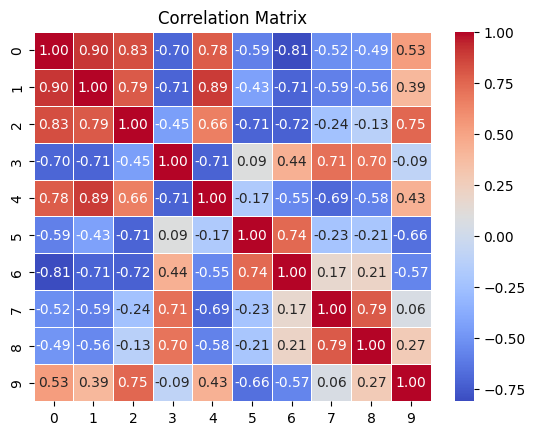

In [4]:
plot_correlation(X)

Можно убрать признаки 0 и 1, тогда корреляция между парами признаков не будет превосходить 0.8

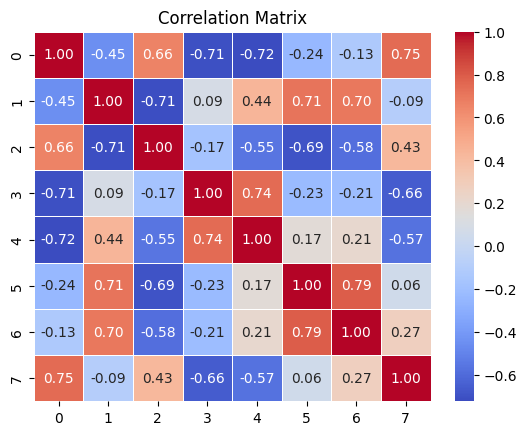

In [5]:
plot_correlation(X[:, 2:])

In [6]:
INDICES_VARIANTS.append([2, 3, 4, 5, 6, 7, 8, 9])

### 2. Выбор переменных с помощью stepwise regression

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector

In [8]:
def select_features(X, y, k_features="best"):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.35, random_state=42
    )

    lr = LinearRegression()

    sfs = SequentialFeatureSelector(
        lr,
        k_features=k_features,
        forward=True,
        floating=False,
        scoring="neg_mean_squared_error",
        cv=5,
    )
    return list(sfs.fit(X_train, y_train).k_feature_idx_)

In [9]:
print(select_features(X, y))
INDICES_VARIANTS.append([2, 3, 4])

[2, 3, 4]


Найдем лучшие 5 фич

In [10]:
print(select_features(X, y, k_features=5))
INDICES_VARIANTS.append([2, 3, 4, 8, 9])

[2, 3, 4, 8, 9]


### 3. Выбор переменных методом разреженной регрессии

In [11]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

In [12]:
def perform_lasso(X, y, alpha=0.2, threshold=0.1, test_size=0.35):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, random_state=42
    )

    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)

    return [i for i, x in enumerate(lasso.coef_) if x > threshold]

In [13]:
print(perform_lasso(X, y))
INDICES_VARIANTS.append([5, 7, 8])

[5, 7, 8]


Найдем побольше лучших фич

In [14]:
print(perform_lasso(X, y, alpha=0.02))
INDICES_VARIANTS.append([1, 5, 7, 8, 9])

[1, 5, 7, 8, 9]


### 4. Выбрать оптимальную модель

In [15]:
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm

In [16]:
def evaluate_indices(indices):
    global X
    global y

    X_train = X[:, indices]
    lr = LinearRegression()

    return float(max(cross_val_score(lr, X_train, y, cv=3))), float(
        sm.OLS(y, X_train).fit().aic
    )

In [17]:
print("индексы | cross-validation score | AIC")
for indices in INDICES_VARIANTS:
    print(indices, *evaluate_indices(indices), sep=" | ")

индексы | cross-validation score | AIC
[2, 3, 4, 5, 6, 7, 8, 9] | 0.7155541520902122 | 158.1210206671771
[2, 3, 4] | 0.7992243625847741 | 171.79224046365619
[2, 3, 4, 8, 9] | 0.7657819504834934 | 164.19887274006888
[5, 7, 8] | 0.6426931712185596 | 179.80584376242103
[1, 5, 7, 8, 9] | 0.7689942839794794 | 159.55119456421497


В данном случае хорошо выглядит вариант [1, 5, 7, 8, 9].

Лучший по кросс-валидации: [2, 3, 4] \
Лучший по AIC: [2, 3, 4, 5, 6, 7, 8, 9]

## Разреженная логистическая регрессия

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [19]:
data = Dataset().datasets["singh2002"]
X = data["x"]
y = data["y"]
y = np.array([1 if x == "cancer" else 0 for x in y])

/home/curlink/workspace/projects/hw_stats/.venv/lib/python3.12/site-packages/rdata/conversion/_conversion.py:294: UserWarning: Unknown encoding. Assumed ASCII.
  warnings.warn("Unknown encoding. Assumed ASCII.")  # noqa: B028


In [20]:
def logreg(penalty="l1", C=1):
    global X
    global y

    print(f"penalty: {penalty}")
    print(f"C: {C}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model = LogisticRegression(penalty=penalty, solver="saga", max_iter=3000, C=C)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("Non-zero features num " + str(len(np.where(model.coef_ != 0)[1])))

In [21]:
logreg()

penalty: l1
C: 1
Accuracy: 0.8571
Non-zero features num 97


/home/curlink/workspace/projects/hw_stats/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [22]:
logreg(penalty="l2")

penalty: l2
C: 1
Accuracy: 0.6667
Non-zero features num 6033
